# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></div><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset</a></div><div class="lev1 toc-item"><a href="#Custom-components" data-toc-modified-id="Custom-components-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Custom components</a></div><div class="lev2 toc-item"><a href="#Definition" data-toc-modified-id="Definition-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Definition</a></div><div class="lev2 toc-item"><a href="#Demo" data-toc-modified-id="Demo-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Demo</a></div><div class="lev1 toc-item"><a href="#Pipeline" data-toc-modified-id="Pipeline-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Pipeline</a></div><div class="lev2 toc-item"><a href="#Compose" data-toc-modified-id="Compose-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Compose</a></div><div class="lev2 toc-item"><a href="#Fit" data-toc-modified-id="Fit-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Fit</a></div><div class="lev2 toc-item"><a href="#Transform" data-toc-modified-id="Transform-53"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Transform</a></div><div class="lev2 toc-item"><a href="#Predict" data-toc-modified-id="Predict-54"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Predict</a></div><div class="lev1 toc-item"><a href="#Feature-importances" data-toc-modified-id="Feature-importances-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature importances</a></div><div class="lev2 toc-item"><a href="#Handmade-plot" data-toc-modified-id="Handmade-plot-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Handmade plot</a></div><div class="lev2 toc-item"><a href="#ELI5-table" data-toc-modified-id="ELI5-table-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>ELI5 table</a></div><div class="lev1 toc-item"><a href="#Explaining-a-single-prediction" data-toc-modified-id="Explaining-a-single-prediction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Explaining a single prediction</a></div>

# Description

* Combining Pandas DataFrames with sckit-learn Pipelines
* Preserving original feature names
* Inspecting feature importances
* Explaining a single prediction

# Imports

In [1]:
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

import eli5

%matplotlib inline

# Dataset

In [2]:
train_df = pd.DataFrame([
    ['cool orange sedan',               1.00,   0.61,  'CAR'],
    ['cool white sedan',                0.93,   0.65,  'CAR'],
    ['cool green pickup (very cool!)',  0.57,   0.96,  'TRUCK'],
    ['cool red pickup',                 0.64,   1.00,  'TRUCK'],
], columns=['desc', 'mpg', 'cap', 'label'])
train_df

,desc,mpg,cap,label
0,cool orange sedan,1.00,0.61,CAR
1,cool white sedan,0.93,0.65,CAR
2,cool green pickup (very cool!),0.57,0.96,TRUCK
3,cool red pickup,0.64,1.00,TRUCK


# Custom components

## Definition

In [3]:
class FeaturePipeline(Pipeline):
    
    def get_feature_names(self):
        name, trans = self.steps[-1]
        if not hasattr(trans, 'get_feature_names'):
            raise AttributeError('Transformer %s (type %s) does not '
                                 'provide get_feature_names.' % (str(name), type(trans).__name__))
        return trans.get_feature_names()

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.columns]
        elif isinstance(X, pd.Series):
            if isinstance(self.columns, list):
                return pd.DataFrame([
                    [X[column] for column in self.columns]
                ], columns=self.columns, index=[X.name])
            else:
                return pd.Series([X[self.columns]], name=self.columns, index=[X.name])
        else:
            raise ValueError('Hey! Give me either a DataFrame (table) or a Series (row)!')
    
    def get_feature_names(self):
        if isinstance(self.columns, list):
            return self.columns
        else:    
            return [self.columns]

## Demo

In [5]:
ColumnSelector('desc').transform(train_df)

0                 cool orange sedan
1                  cool white sedan
2    cool green pickup (very cool!)
3                   cool red pickup
Name: desc, dtype: object

In [6]:
ColumnSelector('desc').transform(train_df.iloc[2])

2    cool green pickup (very cool!)
Name: desc, dtype: object

In [7]:
ColumnSelector(['mpg', 'cap']).transform(train_df)

,mpg,cap
0,1.00,0.61
1,0.93,0.65
2,0.57,0.96
3,0.64,1.00


In [8]:
ColumnSelector(['mpg', 'cap']).transform(train_df.iloc[3])

,mpg,cap
3,0.64,1.0


# Pipeline

## Compose

In [9]:
model = Pipeline([
    ('vec', FeatureUnion([

        ('desc_tfidf', FeaturePipeline([
            ('sel', ColumnSelector('desc')),
            ('vec', TfidfVectorizer(min_df=2))
        ])),

        ('desc_cnt', FeaturePipeline([
            ('sel', ColumnSelector('desc')),
            ('vec', CountVectorizer(min_df=3))
        ])),
    
        ('numerics', ColumnSelector(['mpg', 'cap']))

    ])),
   
    ('clf', LogisticRegression())
])

## Fit

In [10]:
model.fit(train_df, train_df.label)

Pipeline(memory=None,
     steps=[('vec', FeatureUnion(n_jobs=1,
       transformer_list=[('desc_tfidf', FeaturePipeline(memory=None,
        steps=[('sel', ColumnSelector(columns='desc')), ('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', in...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## Transform

In [11]:
model.named_steps.vec.get_feature_names()

[u'desc_tfidf__cool',
 u'desc_tfidf__pickup',
 u'desc_tfidf__sedan',
 u'desc_cnt__cool',
 'numerics__mpg',
 'numerics__cap']

In [12]:
pd.DataFrame(model.named_steps.vec.transform(train_df).todense(),
             columns=model.named_steps.vec.get_feature_names())

,desc_tfidf__cool,desc_tfidf__pickup,desc_tfidf__sedan,desc_cnt__cool,numerics__mpg,numerics__cap
0,0.551939,0.000000,0.833884,1.0,1.00,0.61
1,0.551939,0.000000,0.833884,1.0,0.93,0.65
2,0.797922,0.602761,0.000000,2.0,0.57,0.96
3,0.551939,0.833884,0.000000,1.0,0.64,1.00


## Predict

In [13]:
model.predict(train_df)

array(['CAR', 'CAR', 'TRUCK', 'TRUCK'], dtype=object)

In [14]:
model.predict(train_df.iloc[3])

array(['TRUCK'], dtype=object)

# Feature importances

## Handmade plot

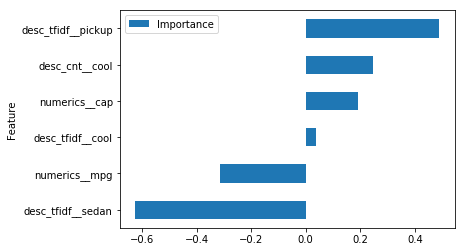

In [15]:
pd.DataFrame({
    'Feature': model.named_steps.vec.get_feature_names(),
    'Importance': model.named_steps.clf.coef_.ravel()
}).set_index('Feature').sort_values('Importance').plot.barh()

## ELI5 table

In [16]:
eli5.show_weights(model)

Weight?,Feature
+0.490,desc_tfidf:pickup
+0.247,desc_cnt:cool
+0.191,numerics:cap
+0.038,desc_tfidf:cool
-0.074,<BIAS>
-0.313,numerics:mpg
-0.626,desc_tfidf:sedan


# Explaining a single prediction

In [17]:
eli5.show_prediction(
    model.named_steps.clf,
    feature_names=model.named_steps.vec.get_feature_names(),
    doc=model.named_steps.vec.transform(train_df.iloc[3])
)